### Recurrent Neural Network

#### Basic data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 12

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

##### Time Series Data

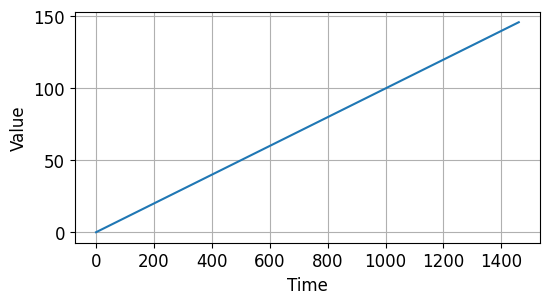

In [5]:
def trend(time, slope=0):
    return slope * time

time = np.arange(4 * 365 + 1)
series = trend(time, slope=0.1)

plot_series(time, series)
plt.show()

##### Seasonal Time Series Data

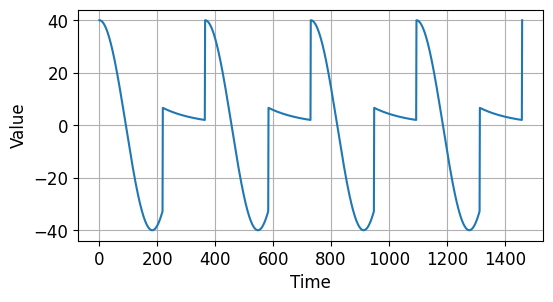

In [3]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.6,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plot_series(time, series)
plt.show()

##### Seasonal + Trend Time Series Data

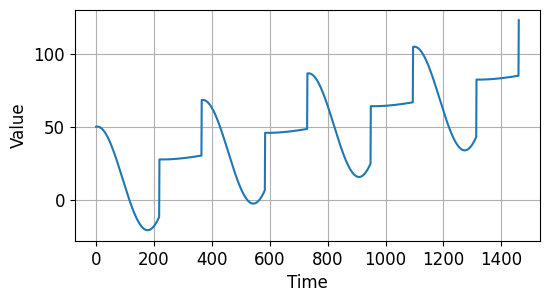

In [7]:
baseline = 10
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plot_series(time, series)
plt.show()

Noise Generator

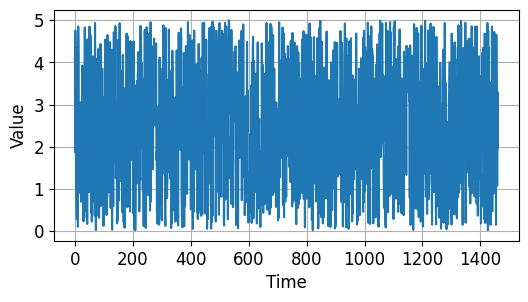

In [8]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.rand(len(time)) * noise_level

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plot_series(time, noise)
plt.show()

##### Seasonal + Trend + Noise Time Series Data

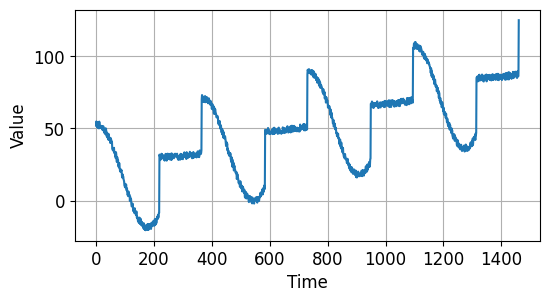

In [9]:
baseline = 10
slope = 0.05
noise_level = 5
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) \
        + white_noise(time, noise_level, seed=42)

plot_series(time, series)
plt.show()

##### Autocorrelation Time Series Data
<br>
- autocorrelation : The relationship between the present state and the data of the past and the future

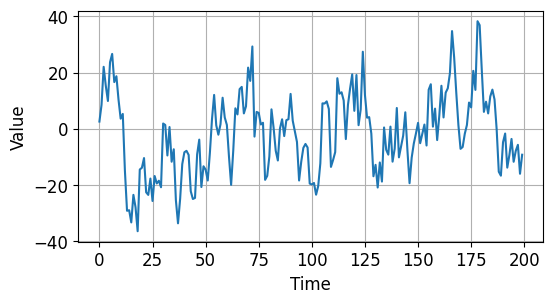

In [10]:
split_time = 1000
time_train, x_train = time[:split_time], series[:split_time]
time_valid, x_valid = time[split_time:], series[split_time:]

def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    pi = 0.8
    ar =  rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += pi * ar[step - 1]       ## 이전의 값의 0.8배를 더하기
    return ar[1:] * amplitude

series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

##### Autocorrelation + Trend Time Series Data

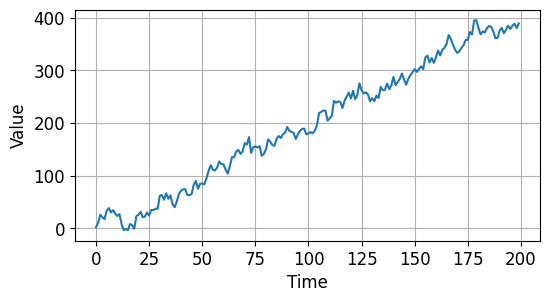

In [11]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

##### Autocorrelation + Trend + Seasonal Time Series Data

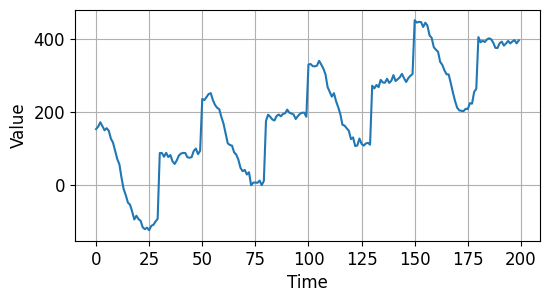

In [12]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

##### Autocorrelation + Trend + Seasonal + Different Feature Time Series Data

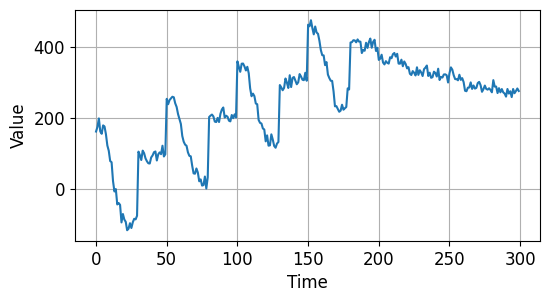

In [13]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]        # 자기상관 amp 10->5, 계절성 amp 150->2, 경향성 slope 2->-1 + 550
series += white_noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

#### RNN Example

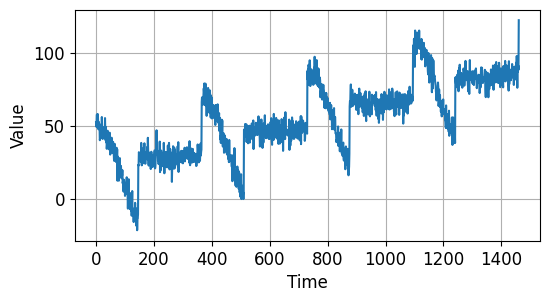

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# 1. 기본 스타일 설정
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 12


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

plot_series(time, series)
plt.show()

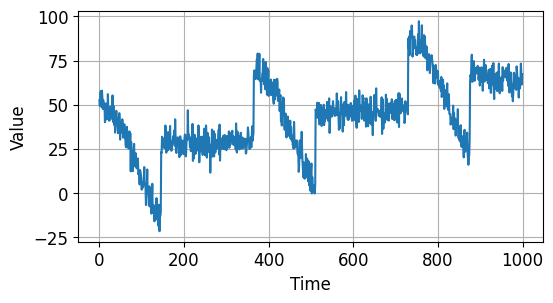

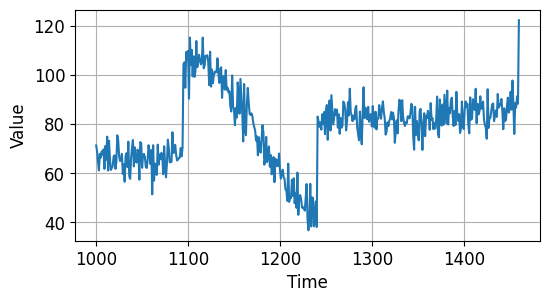

In [18]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train)
plt.show()

plot_series(time_valid, x_valid)
plt.show()

In [33]:
print(f"Counts of Total Data : {len(series)}\nCounts of Train Data : {len(x_train)}\nCounts of Validation Data : {len(x_valid)}")

Counts of Total Data : 1461
Counts of Train Data : 1000
Counts of Validation Data : 461


##### Basic Predict

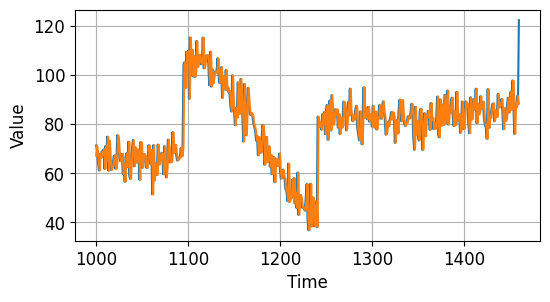

In [34]:
# Naive Forecast : Models predicting the following values from previous data
    # Data one step ahead
naive_forecast = series[split_time - 1: -1]
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

In [36]:
# Errors MSE, MSA
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.9379086


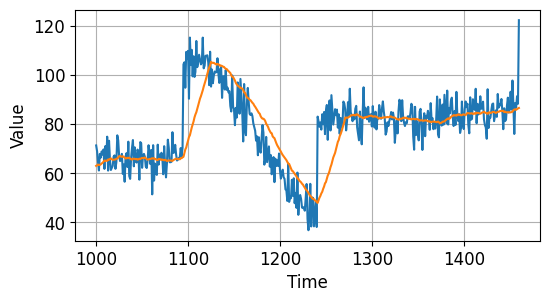

In [37]:
# Moving average (30 Times)
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time: time + window_size].mean())
    return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [38]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


##### Weather Dataset with RNN

In [39]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
  origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
  fname='jena_climate_2009_2016.csv.zip',
  extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 1s 0us/step


In [45]:
df = pd.read_csv(csv_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [46]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [48]:
print(f"Counts of Total Data : {len(df)}\nCounts of Features : {len(df.columns)}")

Counts of Total Data : 420551
Counts of Features : 15


In [41]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [42]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [49]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.head())

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64


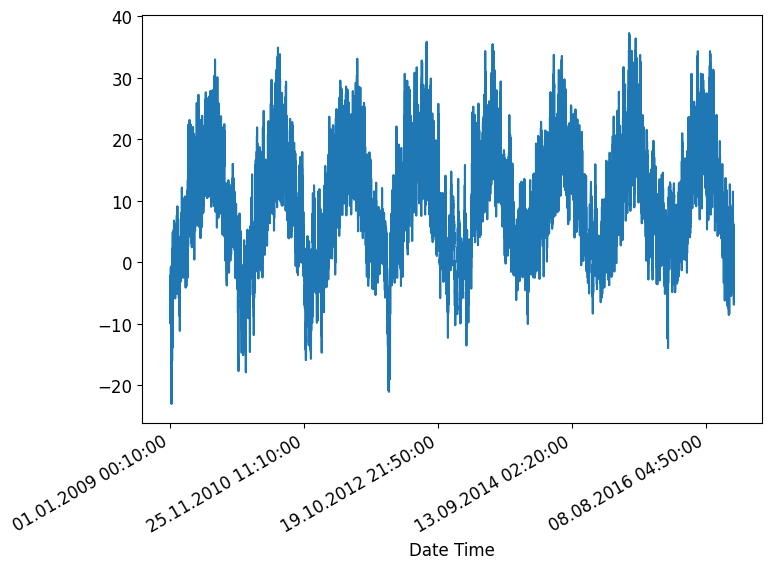

In [50]:
uni_data.plot(subplots=True)
plt.show()

In [51]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

print(uni_data)

[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]


In [52]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [53]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

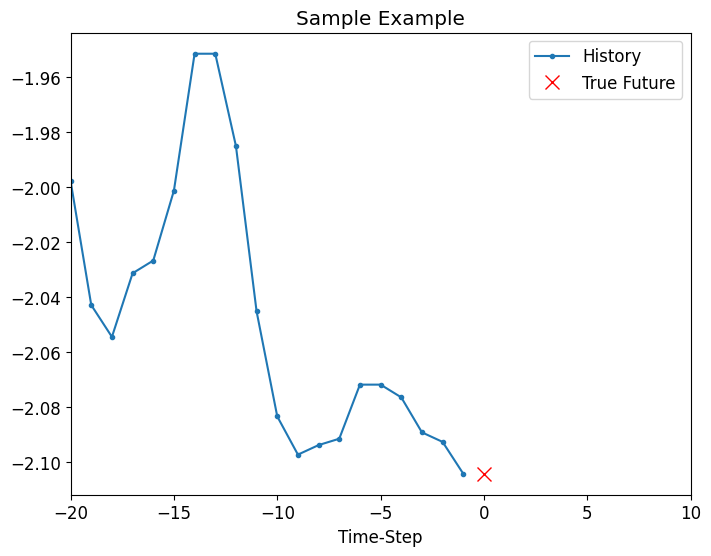

In [54]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

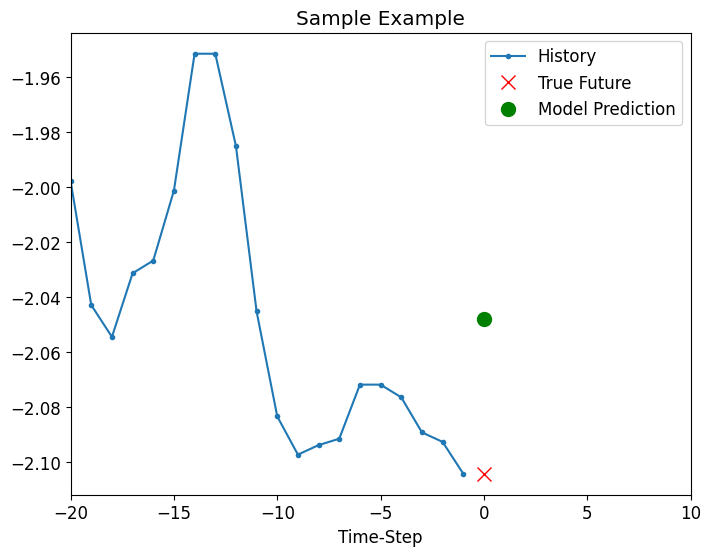

In [55]:
# baseline : A function that receives the past 20 data and returns its mean
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()